In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd 
import numpy as np

# set max column 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
all_files = os.listdir('collected_results/')
print(all_files)
# concat
df = pd.concat((pd.read_csv('collected_results/' + f) for f in all_files))

['JAEHO_V100_COBRA_experimentruns.csv', 'A5000_torch_1.10_weebum.csv', 'JAEHO_RTXTITAN_experimentruns.csv', 'BOSUNG_experimentruns_a6000.csv', 'BOSUNG_experimentruns_pt1.10.csv', 'JAEHO_V100_NIPA_experimentruns.csv']


In [3]:
# remove nipa gpu result
df['PERSON'].unique()
df = df[df['PERSON']!='JAEHO_V100_NIPA']
df = df[df['pred_len'].isin([96, 720])]
df = df[df['data_name']=='ETTh1']
# df = df[df['device_name']!='NVIDIA RTX A5000']
df['device_name'].unique()


array(['Tesla V100-PCIE-32GB', 'NVIDIA RTX A5000', 'TITAN RTX',
       'NVIDIA RTX A6000', 'NVIDIA GeForce RTX 3090'], dtype=object)

In [4]:
batch32_96_amp = df[(df['pred_len']==96) & (df['batch_size']==32) & (df['use_amp']==True)]
#batch32_720_amp = df[(df['pred_len']==720) & (df['batch_size']==32) & (df['use_amp']==True)]
batch128_96_amp = df[(df['pred_len']==96) & (df['batch_size']==128) & (df['use_amp']==True)]
#batch128_720_amp = df[(df['pred_len']==720) & (df['batch_size']==128) & (df['use_amp']==True)]

batch32_96 = df[(df['pred_len']==96) & (df['batch_size']==32) & (df['use_amp']==False)]
#batch32_720 = df[(df['pred_len']==720) & (df['batch_size']==32) & (df['use_amp']==False)]
batch128_96 = df[(df['pred_len']==96) & (df['batch_size']==128) & (df['use_amp']==False)]
#batch128_720 = df[(df['pred_len']==720) & (df['batch_size']==128) & (df['use_amp']==False)]
# batch32_720 = df[(df['pred_len']==720) & (df['batch_size']==32)]
# batch128_96 = df[(df['pred_len']==96) & (df['batch_size']==128)]
# batch128_720 = df[(df['pred_len']==720) & (df['batch_size']==128)]

In [5]:
df.groupby(['device_name','pytorch_ver','use_amp','model_name','pred_len'])[['max_memory_mb','mae', 'mse','secs/batch', 'secs/epoch']].describe().loc[:,(slice(None),['mean','std'])]

max_memory_mb  \
                                                                           mean   
device_name             pytorch_ver  use_amp model_name  pred_len                 
NVIDIA GeForce RTX 3090 1.10.1       False   Dlinear     96           26.076160   
                                                         720         133.757696   
                                             Informer    96         1612.673024   
                                                         720        6507.206656   
                                             Transformer 96         2121.265152   
                                                         720       10968.069632   
                                     True    Dlinear     96           22.400000   
                                                         720         112.399616   
                                             Informer    96         1076.153088   
                                                         720        3529.241856   
                                             Transformer 96         1414.205184   
                                                         720        7336.941312   
NVIDIA RTX A5000        1.10.0       False   Dlinear     96           26.076160   
                                                         720         133.757696   
                                             Informer    96         1612.673024   
                                                         720        2729.486848   
                                             Transformer 96         2121.265152   
                                                         720       10968.069633   
                                     True    Dlinear     96           22.400000   
                                                         720         112.399616   
                                             Informer    96         1076.153088   
                                                         720        3529.241856   
                                             Transformer 96         1414.205184   
                                                         720        7336.941314   
NVIDIA RTX A6000        1.10.1       False   Dlinear     96           26.076160   
                                                         720         133.757696   
                                             Informer    96         1612.673024   
                                                         720        6507.206656   
                                             Transformer 96         2121.265152   
                                                         720       10968.069632   
                                     True    Dlinear     96           22.400000   
                                                         720         112.399616   
                                             Informer    96         1076.153088   
                                                         720        3529.241856   
                                             Transformer 96         1414.991616   
                                                         720        7336.941312   
TITAN RTX               1.10.0       False   Dlinear     96           26.076160   
                                                         720         133.757696   
                                             Informer    96         2733.178368   
                                                         720        6506.377216   
                                             Transformer 96         3243.047936   
                                                         720       10316.220416   
                                     True    Dlinear     96           22.400000   
                                                         720         112.399616   
                                             Informer    96         1121.587712   
                                                         720        3529.241856   

In [15]:
sns.set_theme(style="whitegrid")

In [16]:
def make_catplot_sec(df, title, y_limit, save_name=None):
    g = sns.catplot(
        data=df, kind="bar",
        x="model_name", y="secs/batch", hue="device_name",
        errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
        hue_order=['Tesla V100-PCIE-32GB', 'TITAN RTX', 'NVIDIA GeForce RTX 3090','NVIDIA RTX A6000','NVIDIA RTX A5000']
    )
    g.legend.set_title("GPU", prop={'size': 14, 'weight': 'bold'})
    # # set figure title
    # # set white grid 

    g.fig.suptitle(f"{title}", fontsize=18, fontweight='bold', y=1.05)
    # # set ylim of catplot
    g.set(ylim=(0, y_limit))
    # # set y label
    g.set_ylabels('Second (Batch/sec)', fontsize=14, fontweight='bold')
    # set x label
    g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
    # set x tick label
    g.set_xticklabels(fontsize=12, fontweight='bold')
    if save_name is not None:
        g.savefig(f"figures/gpus_{save_name}_sec.png", dpi=300)

In [23]:
def make_catplot_mem(df, title, y_limit, save_name=None):
    g = sns.catplot(
        data=df, kind="bar",
        x="model_name", y="max_memory_mb", hue="device_name",
        errorbar="sd", palette="dark", alpha=.6, height=6, order=['Transformer','Informer','Dlinear'],
        hue_order=['Tesla V100-PCIE-32GB', 'TITAN RTX', 'NVIDIA GeForce RTX 3090','NVIDIA RTX A6000','NVIDIA RTX A5000']
    )
    g.legend.set_title("GPU", prop={'size': 14, 'weight': 'bold'})
    # # set figure title
    # # set white grid 

    g.fig.suptitle(f"{title}", fontsize=18, fontweight='bold', y=1.05)
    # # set ylim of catplot
    g.set(ylim=(0, y_limit))
    # # set y label
    g.set_ylabels('Max Memory (mb)', fontsize=14, fontweight='bold')
    # set x label
    g.set_xlabels('Model Name', fontsize=14, fontweight='bold')
    # set x tick label
    g.set_xticklabels(fontsize=12, fontweight='bold')
    if save_name is not None:
        g.savefig(f"figures/gpus_{save_name}_mb.png", dpi=300)

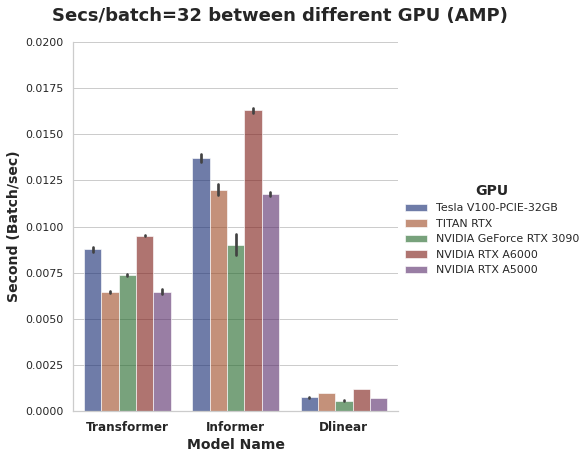

In [17]:
make_catplot_sec(batch32_96_amp, "Secs/batch=32 between different GPU (AMP)", 0.02, 'batch32_96_amptrue')

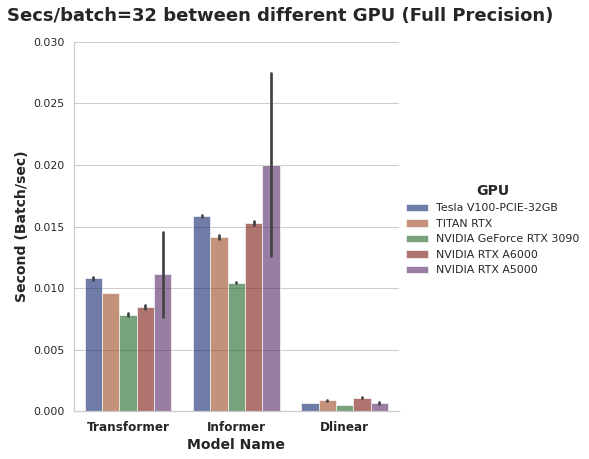

In [19]:
make_catplot_sec(batch32_96, "Secs/batch=32 between different GPU (Full Precision)", 0.03, 'batch32_96_ampfalse')

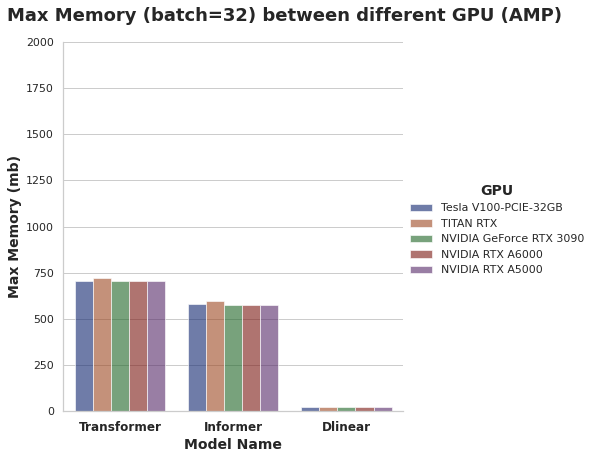

In [30]:
make_catplot_mem(batch32_96_amp, "Max Memory (batch=32) between different GPU (AMP)", 2000, 'batch32_96_amptrue')

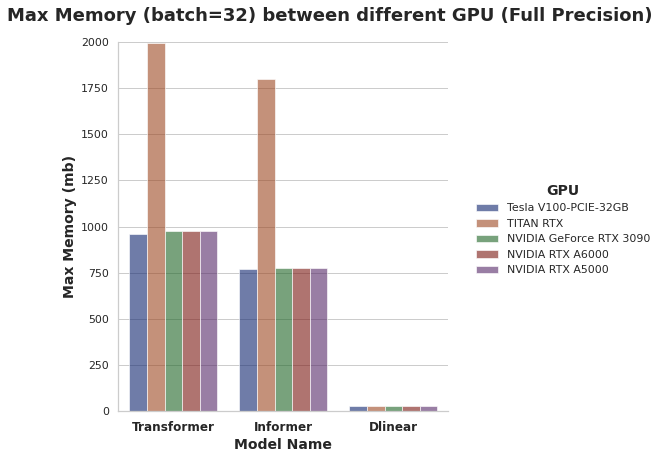

In [29]:
make_catplot_mem(batch32_96, "Max Memory (batch=32) between different GPU (Full Precision)", 2000, 'batch32_96_ampfalse')